# $\textit{Detección de ondas gravitatorias}$
$\textit{Estimación Espectral No Paramétrica}$

In [3]:
#En ppio hay que elegir entre 32sec • 4KHz o 4096sec • 4KHz. Esto porque el evento esta alrededor de los 2Khz.
#Ademas, usamos el dataset de 4096 seg porque el ruido es localmente estacionario (hay que probarlo).

In [4]:
%matplotlib widget
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd

In [5]:
# Creditos: https://stackoverflow.com/questions/31410043/hiding-lines-after-showing-a-pyplot-figure, by Basj

class InteractiveLegend(object):
    def __init__(self, legend=None):
        if legend == None:
            legend = plt.gca().get_legend()
        self.legend = legend
        self.fig = legend.axes.figure
        self.lookup_artist, self.lookup_handle = self._build_lookups(legend)
        self._setup_connections()
        self.update()
    def _setup_connections(self):
        for artist in self.legend.texts + self.legend.legendHandles:
            artist.set_picker(10) # 10 points tolerance
        self.fig.canvas.mpl_connect('pick_event', self.on_pick)
        self.fig.canvas.mpl_connect('button_press_event', self.on_click)
    def _build_lookups(self, legend):
        labels = [t.get_text() for t in legend.texts]
        handles = legend.legendHandles
        label2handle = dict(zip(labels, handles))
        handle2text = dict(zip(handles, legend.texts))
        lookup_artist = {}
        lookup_handle = {}
        for artist in legend.axes.get_children():
            if artist.get_label() in labels:
                handle = label2handle[artist.get_label()]
                lookup_handle[artist] = handle
                lookup_artist[handle] = artist
                lookup_artist[handle2text[handle]] = artist
        lookup_handle.update(zip(handles, handles))
        lookup_handle.update(zip(legend.texts, handles))
        return lookup_artist, lookup_handle
    def on_pick(self, event):
        handle = event.artist
        if handle in self.lookup_artist:
            artist = self.lookup_artist[handle]
            artist.set_visible(not artist.get_visible())
            self.update()
    def on_click(self, event):
        if event.button == 3:
            visible = False
        elif event.button == 2:
            visible = True
        else:
            return
        for artist in self.lookup_artist.values():
            artist.set_visible(visible)
        self.update()
    def update(self):
        for artist in self.lookup_artist.values():
            handle = self.lookup_handle[artist]
            if artist.get_visible():
                handle.set_visible(True)
            else:
                handle.set_visible(False)
        self.fig.canvas.draw()

In [6]:
sns.set_theme()

In [7]:
# these 4096 second files are useful for computing more accurate psds
largeFilenamePart = {'GW150914': 'GWOSC_4KHZ_R1-1126257415-4096.hdf5'}
# largeFilenamePart = {'GW150914': 'GWOSC_4KHZ_R1-1126259447-32.hdf5'}
fn_H1 = './Data/H-H1_' + largeFilenamePart['GW150914']
fn_L1 = './Data/L-L1_' + largeFilenamePart['GW150914']

# this is the approximate event time which is used in the papers
time_center = 1126259462

# get sample rate from the H1 data file
with h5py.File(fn_H1, 'r') as hdf_file:
    dt = hdf_file['strain/Strain'].attrs['Xspacing']
fs = int(1.0/dt)
print("Using sample rate of {0} Hz found in file: {1}".format(fs, fn_H1))

Using sample rate of 4096 Hz found in file: ./Data/H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5


In [8]:
import readligo as rl
strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')
strain_L1, time_L1, chan_dict_L1 = rl.loaddata(fn_L1, 'L1')

In [9]:
len(strain_H1)

16777216

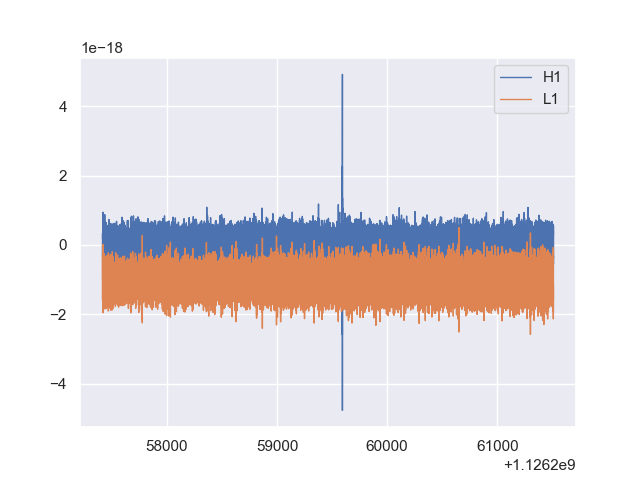

In [10]:
plt.figure()
plt.plot(time_H1, strain_H1, linewidth=1, label='H1')
plt.plot(time_L1, strain_L1, linewidth=1, label='L1')
plt.legend()

In [11]:
np.mean(strain_L1)

-1.056795035519794e-18

In [12]:
indxt_around_H1 = np.where((time_H1 >= time_center - 2) & (time_H1 < time_center + 2))
indxt_around_L1 = np.where((time_L1 >= time_center - 2) & (time_L1 < time_center + 2))

In [13]:
indxt_around_L1

(array([8376320, 8376321, 8376322, ..., 8392701, 8392702, 8392703],
       dtype=int64),)

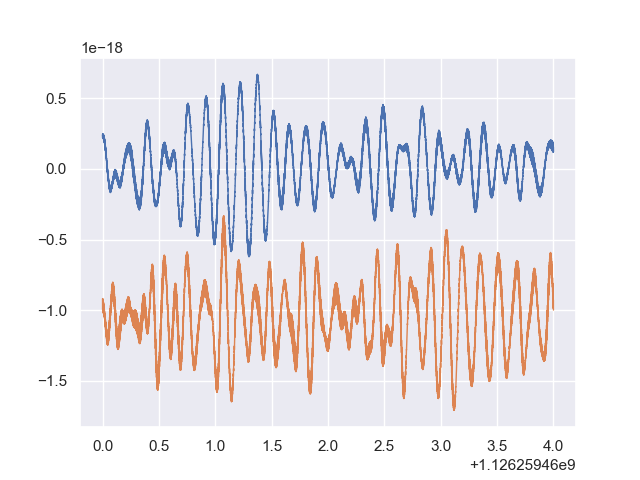

In [14]:
plt.figure()
plt.plot(time_H1[indxt_around_H1], strain_H1[indxt_around_H1], linewidth=1)
plt.plot(time_L1[indxt_around_L1], strain_L1[indxt_around_L1], linewidth=1)

# $\textit{Elegimos la ventana}$

In [15]:
from numpy.fft import fft, rfft
from numpy.fft import fftshift, fftfreq, rfftfreq
from scipy import signal as sg
from scipy.interpolate import interp1d

In [16]:
N = 8192
n = np.linspace(0,N-1,N)

SquareW = sg.windows.boxcar(N) #Square window
TriangW = sg.windows.triang(N) #Triangular window
BlkHarrW = sg.windows.blackmanharris(N)
ParzenW = sg.windows.parzen(N)
kaiserW = sg.windows.kaiser(N, 10)
tukeyW = sg.windows.tukey(N, 0.9)   # 

currWindow = kaiserW #Choose window

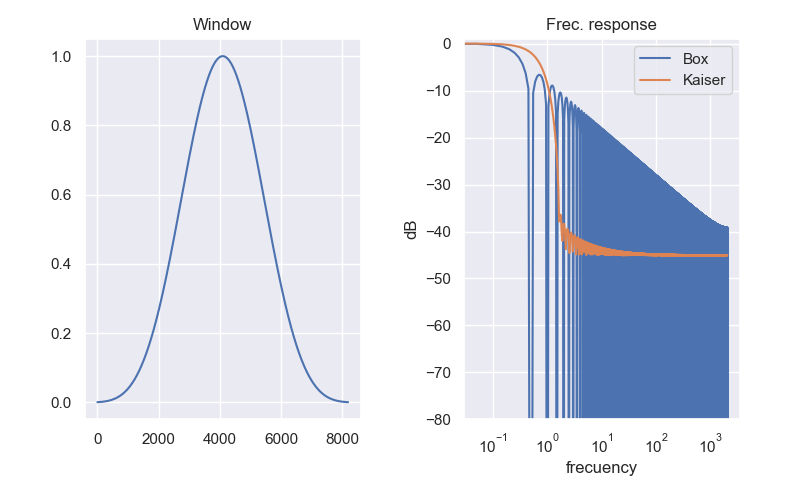

In [40]:
fig, axs = plt.subplots(1, 2)
fig.tight_layout(pad=2)
fig.set_figwidth(8)


A = rfft(currWindow, N*10) 
box = rfft(SquareW, N*10)
freq = rfftfreq(N*10, 1/fs)
response = 10*np.log10((np.abs(A)+1e-1) / abs(A).max())
responsebox = 10*np.log10((np.abs(box)+1e-18) / abs(box).max())


axs[0].set_title("Window")
axs[0].plot(currWindow)

axs[1].set_title("Frec. response")
axs[1].plot(freq, responsebox, label='Box')
axs[1].plot(freq, response, label='Kaiser')
axs[1].set_xlabel("frecuency")
axs[1].set_ylabel("dB")
axs[1].set_xscale('log')
axs[1].set_ylim(-80, 1)
plt.legend()

# $\textit{Agarramos los datos sin el evento en ventanas}$

In [18]:

#Getting a neighbourhood of the event
strain_H1_after_noise = strain_H1[indxt_around_H1[0][-1]+1:]
strain_L1_after_noise = strain_L1[indxt_around_L1[0][-1]+1:]
strain_H1_before_noise = strain_H1[:indxt_around_H1[0][0]]
strain_L1_before_noise = strain_L1[:indxt_around_L1[0][0]]

getChuncks = lambda lst, K: [lst[i:i + K] for i in range(0, len(lst), K)][:-1]


In [19]:
len(getChuncks(strain_H1_after_noise, 100))

83845

# $\textit{Calculamos la PSD}$

In [20]:
def PSD(seq, padding_mul):
    rv = sg.correlate(seq, seq, mode="same", method='direct')/len(seq)
    rx = rfft(rv, int(len(rv)*padding_mul))
    Rx = np.abs(rx)
    freq = rfftfreq(int(len(rv)*padding_mul), 1/fs)
    return freq, Rx

In [21]:
def PSD(seq, padding_mult):
    SeqF = rfft(seq, int(len(seq)*padding_mult))
    psd = np.abs(SeqF)**2 / (len(seq))
    freq = rfftfreq(int(len(seq)*padding_mult), 1/fs)
    return freq, psd

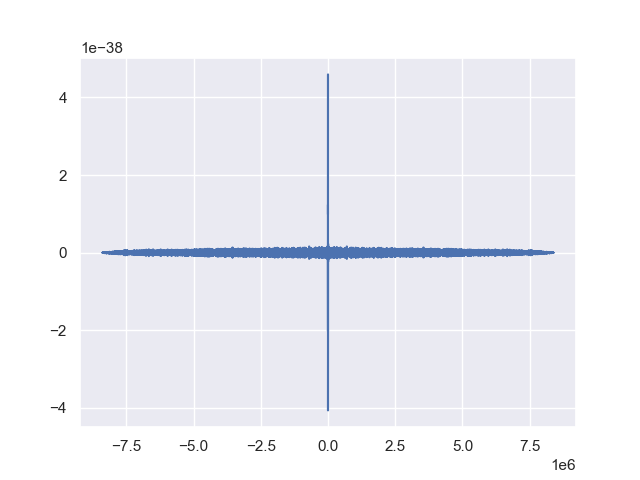

In [22]:
plt.figure()
rv = sg.correlate(strain_H1_after_noise, strain_H1_after_noise, mode="full")/len(strain_H1_after_noise)
lags = sg.correlation_lags(len(strain_H1_after_noise), len(strain_H1_after_noise), mode ="full")
plt.plot(lags, rv)


Esta autocorrelacion se realiza a traves del camino de la fft utilizando todas las muestras presentes luego del evento del dataset de 4096 segundos. Se puede ver que la correlacion es mas alta dentro de un intervalo de aproximadamente 30 seg y luego se achica y parece permanecer con una amplitud mas pequeña en comparacion con el centro. Esto no necesariamente indica que las muestras sean poco correlacionadas en ventanas de 30 seg ya que no se puede asegurar la estacionaridad de la señal en el intervalo de tiempo utilizado. En caso de que fuera estacionario, este resultado es evidencia de que para intervalos de mas de 30 seg la correlacion es bastante menor.

A) Segun el grafico anterior, se presume que el ruido tiene correlacion en un intervalo de alrededor de 30 seg, por lo que a priori nos indica que deberiamos utilizar una ventana de datos mayor a 30 para evitar la perdida de informacion. Creemos que deberiamos usar un ventana de al menos 4 veces 30, es decir 120 segundos. Esto ultimo se vuelve impracticable debido a los recursos de computo necesarios. Por esto, se utilizo una ventana de 32 segundos.

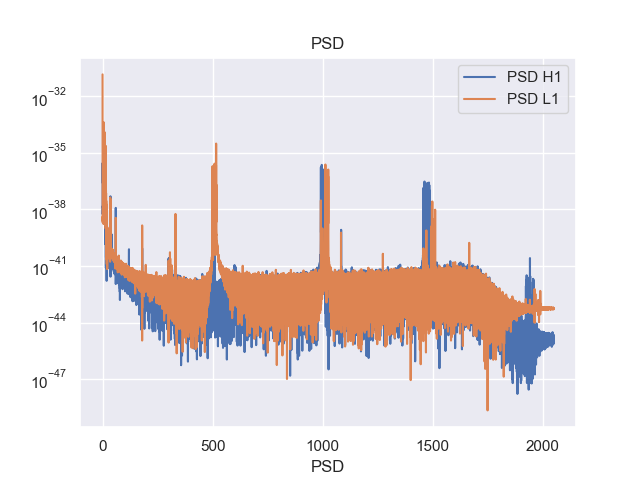

In [42]:
psd_freqH1, psdH1 = PSD(strain_H1_after_noise[:32*fs], 1)
psd_freqL1, psdL1 = PSD(strain_L1_after_noise[:32*fs], 1)

plt.figure()

plt.title("PSD")
plt.plot(psd_freqH1, psdH1, label='PSD H1')
plt.plot(psd_freqL1, psdL1, label='PSD L1')

plt.yscale('log')
plt.xlabel('Freq [Hz]')
plt.xlabel('PSD')
plt.legend(loc='upper right')
leg1 = InteractiveLegend()


In [24]:
plt.close()

# $\textit{Periodogram Averaging}$

C) Segun la teoria vista en clase, utilizamos N como la maxima cantidad de datos disponibles (quitando una seccion de 4 segundos donde se encuentra el evento). Ademas, el L = 16384. Esto ultimo se definio empiricamente observando los graficos y analizando cual de todos nos da una mejor resolucion en frecuencia evitando que K sea muy pequeño, ya que si K fuese muy pequeño la varianza del estimador seria considerablemente grande. No se notaron diferencias significativas entre las distintas ventanas excepto la boxcar y la de hamming, que fueron las que peor desempeño tuvieron.

In [25]:
def periodogram_averaging(data, L, padding_multiplier, window):
    wind = window(L)
    corrFact = np.sqrt(L/np.square(wind).sum()) #Normalizamos la ventana para que sea asintoticamente libre de bias
    wind =  wind*corrFact
    dataChunks = getChuncks(data, L)*wind
    fftwindowSize = L*padding_multiplier
    freqs = rfftfreq(fftwindowSize, 1/fs)
    periodogram = np.zeros(len(freqs))
    for i in range(len(dataChunks)):
        # Se van agregando al promediado los periodogramas de cada bloque calculado a partir de la FFT del señal en el tiempo
        periodogram = periodogram + np.abs(rfft(dataChunks[i], fftwindowSize))**2/(L*len(dataChunks))   

    return freqs, periodogram, len(dataChunks)


windows = ['boxcar', 'triang', 'parzen', 'bohman', 'blackman', 'nuttall',
           'blackmanharris', 'flattop', 'bartlett', 'barthann',
           'hamming', ('kaiser', 10), ('tukey', 0.25)]

No such comm: 7ed42595c3c74efc817e79713c97a874


No such comm: 5f68ccb459214dd9ae4d397fd1907909


## H1

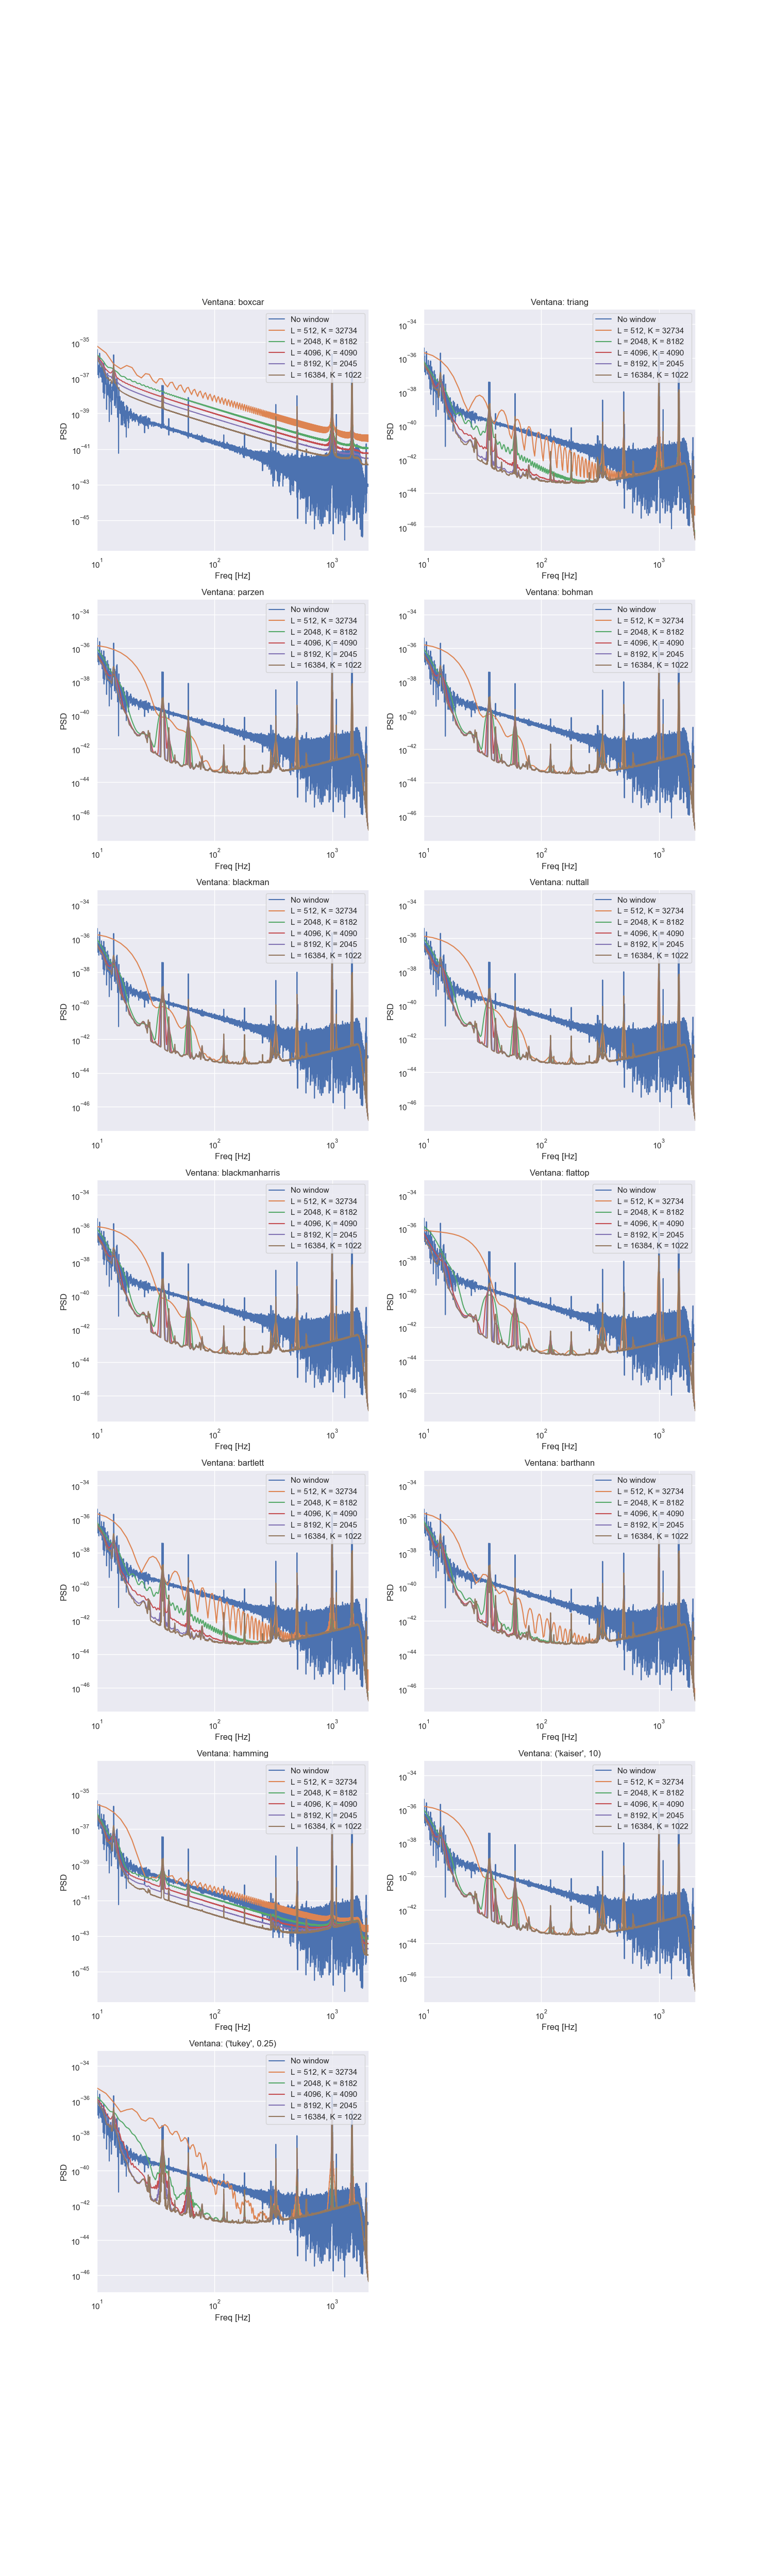

In [26]:

plt.figure(figsize=(15, 50))
legs = [0]*len(windows)

for i, win in enumerate(windows):
    plt.subplot(len(windows) // 2 + len(windows) % 2, 2, i+1)
    plt.plot(psd_freqH1, psdH1, label="No window")
    plt.title(f'Ventana: {win}')
    for size in [512, 2048, 4096, 8192, 16384]:
        window = lambda x: sg.windows.get_window(win, x)
        freqs, after_preiodogram, Kaf = periodogram_averaging(strain_H1_after_noise, size, 4, window)
        freqs, bf_preiodogram, Kbf = periodogram_averaging(strain_H1_before_noise, size, 4, window)
        mean_periodogram = (after_preiodogram + bf_preiodogram)/2
        plt.plot(freqs, mean_periodogram, label=f"L = {size}, K = {Kaf + Kbf}")
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Freq [Hz]')
    plt.ylabel('PSD')
    plt.xlim(10, fs/2)
    plt.legend(loc='upper right')
    legs[i] = InteractiveLegend()



In [27]:
size =16384
window = lambda x: sg.windows.get_window('flattop', x)
freqs, after_preiodogram, Kaf = periodogram_averaging(strain_H1_after_noise, size, 4, window)
paH1freqs, bf_preiodogram, Kbf = periodogram_averaging(strain_H1_before_noise, size, 4, window)
Rxpa_estH1 = (after_preiodogram + bf_preiodogram)/2

## L1

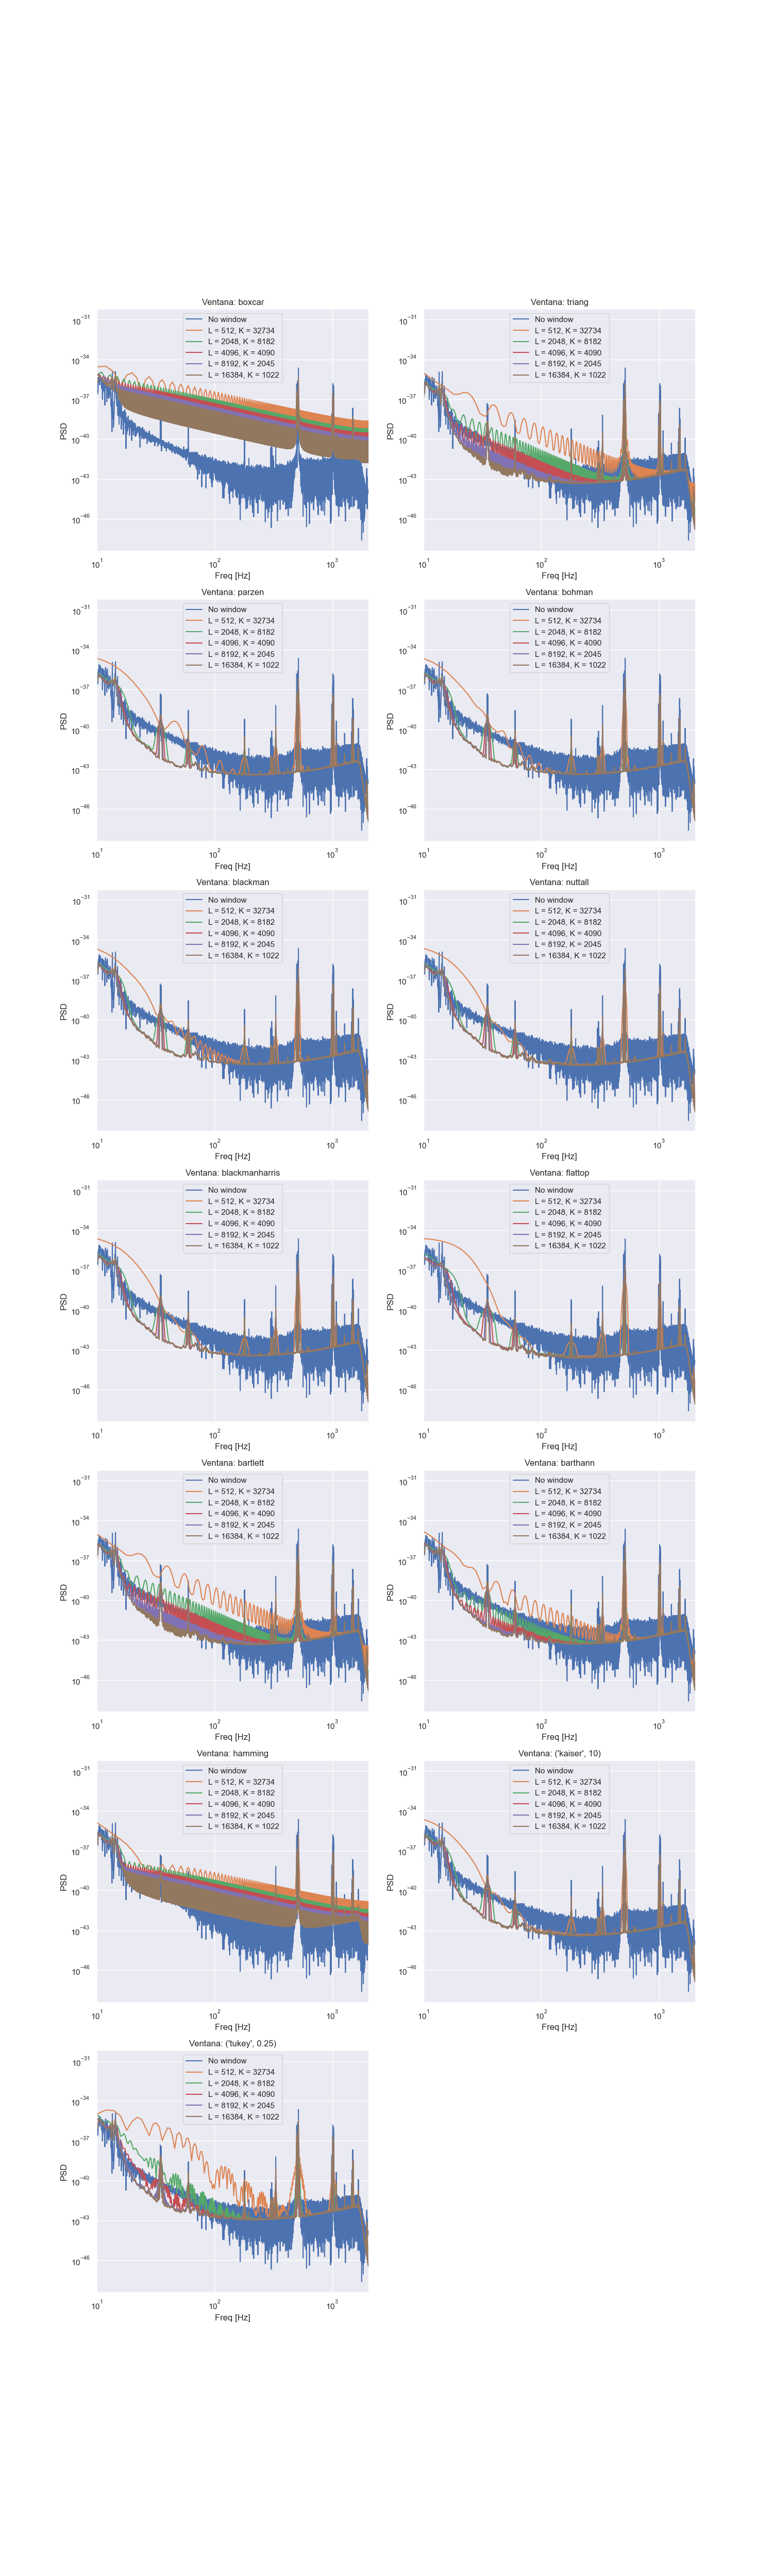

In [28]:
plt.figure(figsize=(15, 50))
legs = [0]*len(windows)

for i, win in enumerate(windows):
    plt.subplot(len(windows) // 2 + len(windows) % 2, 2, i+1)
    plt.plot(psd_freqL1, psdL1, label="No window")
    plt.title(f'Ventana: {win}')
    for size in [512, 2048, 4096, 8192, 16384]:
        window = lambda x: sg.windows.get_window(win, x)
        freqs, after_preiodogram, Kaf = periodogram_averaging(strain_L1_after_noise, size, 4, window)
        freqs, bf_preiodogram, Kbf = periodogram_averaging(strain_L1_before_noise, size, 4, window)
        mean_periodogram = (after_preiodogram + bf_preiodogram)/2
        plt.plot(freqs, mean_periodogram, label=f"L = {size}, K = {Kaf + Kbf}")
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Freq [Hz]')
    plt.ylabel('PSD')
    plt.xlim(10, fs/2)
    plt.legend()
    legs[i] = InteractiveLegend()

In [29]:
size = 16384
window = lambda x: sg.windows.get_window('flattop', x)
freqs, after_preiodogram, Kaf = periodogram_averaging(strain_L1_after_noise, size, 4, window)
paL1freqs, bf_preiodogram, Kbf = periodogram_averaging(strain_L1_before_noise, size, 4, window)
Rxpa_estL1 = (after_preiodogram + bf_preiodogram)/2

# $\textit{Periodogram Smoothing}$

B) Para el caso del periodogram smoothing, elegimos N potencia de 2 para realizar la FFT y la mayor cantidad posible manejable para el computo. Ademas, sabemos que para que tenga el menor variaza posible, debemos elegir un
L < N/4. FALTA TERMINAR

## L1

In [43]:
data_lenght = 256*fs
data = strain_L1_before_noise[:data_lenght]
# data_window = sg.windows.tukey(data_lenght, 0.25)
# data *= data_window

lags2get = fs*32
window_size = lags2get*2+1
pading = 2

rx_full = sg.correlate(data, data, method='direct')/data_lenght
lags = sg.correlation_lags(data_lenght, data_lenght)

rx = rx_full[data_lenght-1-lags2get: data_lenght-1+lags2get+1]
window1 = sg.windows.bartlett(window_size)
window2 = sg.windows.parzen(window_size)
window1 = window1/np.max(window1)
window2 = window2/np.max(window2)

vn1 = rx*window1
vn2 = rx*window2
plt.figure()
plt.plot(lags, rx_full)
plt.plot(lags[data_lenght-1-lags2get: data_lenght-1+lags2get+1], vn1)
plt.xlabel('Lags')
plt.ylabel('rx')

Rxps_estL1barlet = np.abs(rfft(vn1, window_size*pading))
Rxps_estL1parzen = np.abs(rfft(vn2, window_size*pading))
psL1freqs = rfftfreq(window_size*pading, 1/fs)

plt.figure()

plt.plot(psd_freqL1, psdL1, label="No window")
plt.plot(psL1freqs, Rxps_estL1barlet, label="Barlett")
plt.plot(psL1freqs, Rxps_estL1parzen, label="Parzen")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Freq [Hz]')
plt.ylabel('PSD')
plt.xlim(10, fs/2)
plt.legend()




KeyboardInterrupt: 

## H1

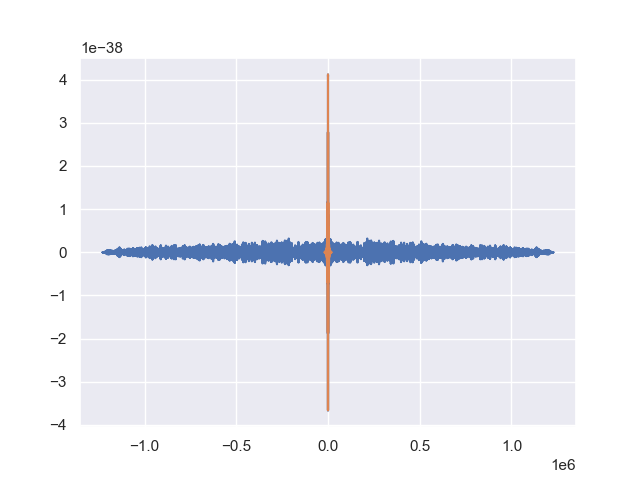

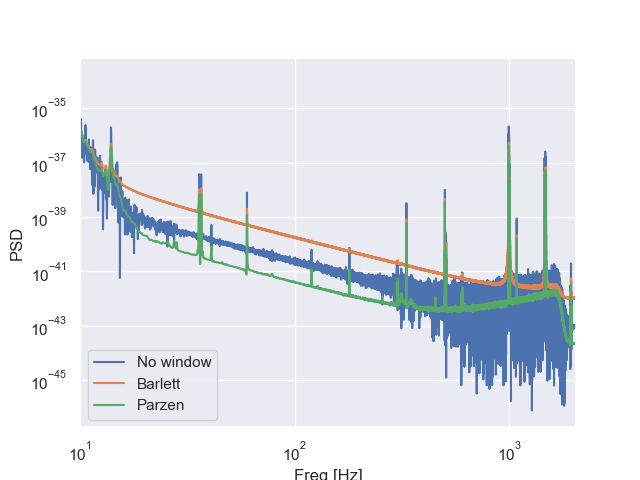

In [31]:
data_lenght = 256*fs
data = strain_H1_before_noise[:data_lenght]
# data_window = sg.windows.tukey(data_lenght, 0.25)
# data *= data_window

lags2get = fs*32
window_size = lags2get*2+1
pading = 2

rx_full = sg.correlate(data, data, method='direct')/data_lenght
lags = sg.correlation_lags(data_lenght, data_lenght)

rx = rx_full[data_lenght-1-lags2get: data_lenght-1+lags2get+1]
window1 = sg.windows.bartlett(window_size)
window2 = sg.windows.parzen(window_size)
window1 = window1/np.max(window1)
window2 = window2/np.max(window2)

vn1 = rx*window1
vn2 = rx*window2
plt.figure()
plt.plot(lags, rx_full)
plt.plot(lags[data_lenght-1-lags2get: data_lenght-1+lags2get+1], vn2)
plt.xlabel('Lags')
plt.ylabel('rx')

Rxps_estH1barlet = np.abs(rfft(vn1, window_size*pading))
Rxps_estH1parzen = np.abs(rfft(vn2, window_size*pading))
psH1freqs = rfftfreq(window_size*pading, 1/fs)

plt.figure()

plt.plot(psd_freqH1, psdH1, label="No window")
plt.plot(psH1freqs, Rxps_estH1barlet, label="Barlett")
plt.plot(psH1freqs, Rxps_estH1parzen, label="Parzen")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Freq [Hz]')
plt.ylabel('PSD')
plt.xlim(10, fs/2)
plt.legend()


# Comparativa

# Filtrado

In [32]:
# Creditos: https://gwosc.org/tutorials/

# La funcion de whitening que utilizan escala el espectro de la señal por 1/sqrt(PSD) para blanquear el ruido sin modificar la fase de la señal.

def whiten(strain, dt, psd_interp, phase_shift=0, time_shift=0):
    """Whitens strain data given the psd and sample rate, also applying a phase
    shift and time shift.

    Args:
        strain (ndarray): strain data
        interp_psd (interpolating function): function to take in freqs and output 
            the average power at that freq 
        dt (float): sample time interval of data
        phase_shift (float, optional): phase shift to apply to whitened data
        time_shift (float, optional): time shift to apply to whitened data (s)
    
    Returns:
        ndarray: array of whitened strain data
    """
    Nt = len(strain)
    # take the fourier transform of the data
    freqs = np.fft.rfftfreq(Nt, dt)

    # whitening: transform to freq domain, divide by square root of psd, then
    # transform back, taking care to get normalization right.
    hf = np.fft.rfft(strain)
    
    # apply time and phase shift
    hf = hf * np.exp(-1.j * 2 * np.pi * time_shift * freqs - 1.j * phase_shift)
    norm = 1./np.sqrt(1./(dt*2))
    white_hf = hf / np.sqrt(psd_interp(freqs)) * norm
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

def bandpass(fl, fh, data):
    b, a = sg.butter(4, [fl, fh], btype='bandpass', fs=fs)
    normalization = np.sqrt((fh-fl)/(fs/2))
    return sg.filtfilt(b, a, data) / normalization

In [33]:


dataH1 = strain_H1[indxt_around_H1]
dataL1 = strain_L1[indxt_around_L1]

# L1_psd_interp = lambda x: np.interp(x, psL1freqs, Rxps_estL1parzen)
# H1_psd_interp = lambda x: np.interp(x, psH1freqs, Rxps_estH1parzen)
L1_psd_interp = lambda x: np.interp(x, paL1freqs, Rxpa_estL1)
H1_psd_interp = lambda x: np.interp(x, paH1freqs, Rxpa_estH1)

whitened_dH1 = whiten(dataH1, 1/fs, H1_psd_interp)
whitened_dL1 = whiten(dataL1, 1/fs, L1_psd_interp)
white_testH1 = whiten(strain_H1_after_noise, 1/fs, H1_psd_interp)
white_testL1 = whiten(strain_L1_after_noise, 1/fs, L1_psd_interp)

filteredH1 = bandpass(35, 350, whitened_dH1)
filteredL1 = bandpass(35, 350, whitened_dL1)


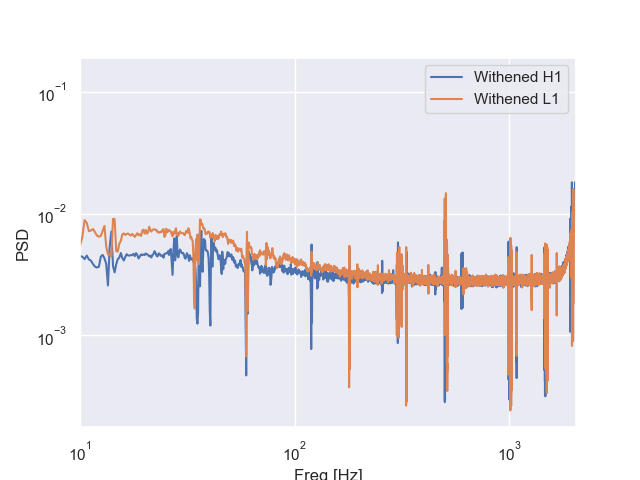

In [34]:
fH1, pH1, _ = periodogram_averaging(white_testH1, 8192, 2, sg.windows.boxcar)
fL1, pL1, _ = periodogram_averaging(white_testL1, 8192, 2, sg.windows.boxcar)
plt.figure()
plt.plot(fH1, pH1, label='Withened H1')
plt.plot(fL1, pL1, label='Withened L1')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Freq [Hz]')
plt.ylabel('PSD')
plt.xlim(10, fs/2)
plt.legend()

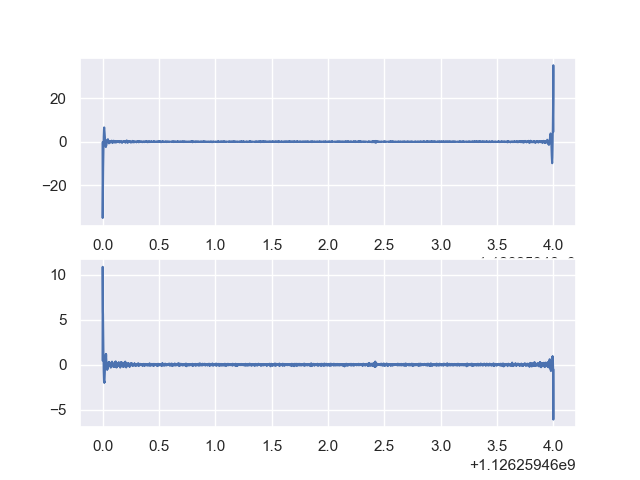

In [35]:
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(time_H1[indxt_around_H1], filteredH1)
plt.subplot(2, 1, 2)
plt.plot(time_L1[indxt_around_L1], filteredL1)

In [36]:
audio = filteredH1[int(0.5*fs):-int(0.5*fs)]
audioobj = ipd.Audio(audio, rate=fs, normalize=True)
audioobj

In [37]:
import soundfile
soundfile.write('GW.wav', audio, fs) 

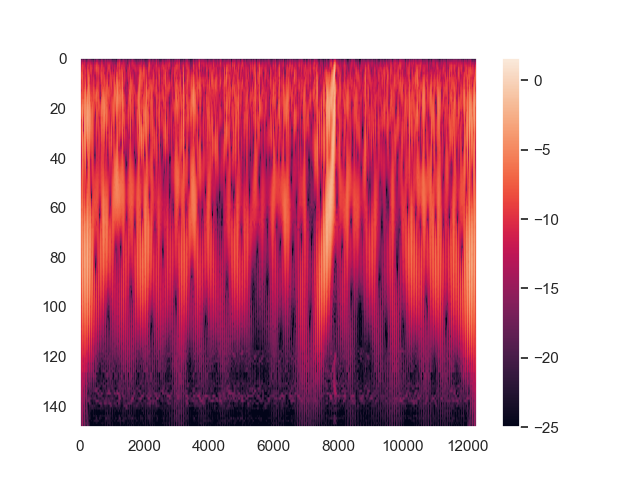

In [38]:
import pywt

data = filteredH1[int(0.5*fs):-int(0.5*fs)]
widths = np.arange(1, 150) #Frecuency range
cwt1, freqs = pywt.cwt(data, widths, 'morl')
cwt2, freqs = pywt.cwt(data, widths, 'mexh')
cwt = cwt1+cwt2
plt.figure()
plt.imshow(X=10*np.log10(abs(cwt)), aspect='auto', vmin=-25)
plt.colorbar()
plt.grid(False)

Tiempo de correlacion minima:  0.0
Tiempo de correlacion minima:  0.00732421875
Tiempo de correlacion minima:  0.00732421875
Tiempo de correlacion minima:  0.00732421875


(-0.006, 0.003)

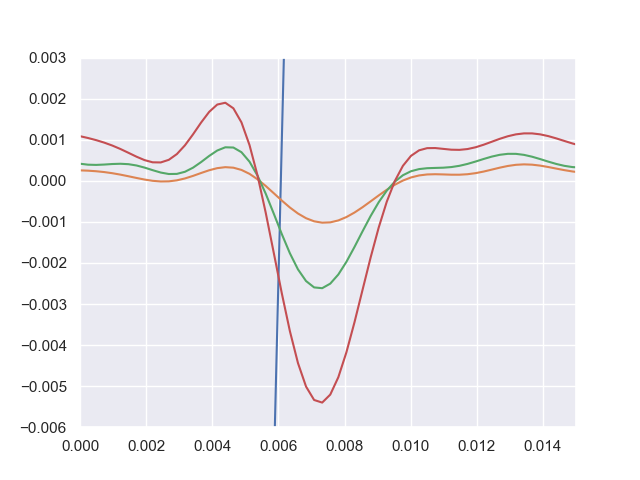

In [39]:
plt.figure()
center_sample = 9750


H1_1s = filteredH1[center_sample-int(0.5*fs): center_sample+int(0.5*fs)]
H1_400ms = filteredH1[center_sample-int(0.2*fs): center_sample+int(0.2*fs)]
H1_200ms = filteredH1[center_sample-int(0.1*fs): center_sample+int(0.1*fs)]

L1_1s = filteredL1[center_sample-int(0.5*fs): center_sample+int(0.5*fs)]
L1_400ms = filteredL1[center_sample-int(0.2*fs): center_sample+int(0.2*fs)]
L1_200ms = filteredL1[center_sample-int(0.1*fs): center_sample+int(0.1*fs)]

cross_corr_long = sg.correlate(filteredH1, filteredL1)/len(filteredH1)
lags_long = sg.correlation_lags(len(filteredH1), len(filteredL1))
cross_corr_1s = sg.correlate(H1_1s, L1_1s)/len(H1_1s)
lags_1s = sg.correlation_lags(len(H1_1s), len(L1_1s))
cross_corr_400ms = sg.correlate(H1_400ms, L1_400ms)/len(H1_400ms)
lags_400ms = sg.correlation_lags(len(H1_400ms), len(L1_400ms))
cross_corr_200ms = sg.correlate(H1_200ms, L1_200ms)/len(H1_200ms)
lags_200ms = sg.correlation_lags(len(H1_200ms), len(L1_200ms))


print("Tiempo de correlacion minima: ", lags_long[np.argmin(cross_corr_long)]/fs)
print("Tiempo de correlacion minima: ", lags_1s[np.argmin(cross_corr_1s)]/fs)
print("Tiempo de correlacion minima: ", lags_400ms[np.argmin(cross_corr_400ms)]/fs)
print("Tiempo de correlacion minima: ", lags_200ms[np.argmin(cross_corr_200ms)]/fs)

plt.plot(lags_long/fs, cross_corr_long)
plt.plot(lags_1s/fs, cross_corr_1s)
plt.plot(lags_400ms/fs, cross_corr_400ms)
plt.plot(lags_200ms/fs, cross_corr_200ms)
plt.xlim(0, 15e-3)
plt.ylim(-0.0060, 0.0030)